In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, roc_curve, precision_recall_curve, roc_auc_score, confusion_matrix, classification_report)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [7]:
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

In [8]:
class ResponsibleIncomePredictor:
    """
    Modelo Random Forest para predicción de ingresos con enfoque en IA Responsable
    - Monitoreo de sesgos algorítmicos
    - Métricas de equidad por grupos demográficos
    - Interpretabilidad del modelo
    """

    def __init__(self, random_state=42):
        self.random_state = random_state
        self.model = None
        self.label_encoders = {}
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.feature_names = None

    def load_and_prepare_data(self, filepath='data/census_income_clean.csv'):
        """
        Carga y prepara los datos basándose en el análisis EDA
        """
        print("🔄 Cargando datos...")
        data = pd.read_csv(filepath)

        # Variables seleccionadas basadas en análisis EDA
        # Top correlaciones/asociaciones identificadas
        selected_features = [
            # Variables numéricas (ordenadas por correlación descendente)
            'education-num',    # r = 0.333 (mayor correlación)
            'age',             # r = 0.230
            'hours-per-week',  # r = 0.228
            'capital-gain',    # r = 0.223
            'capital-loss',    # r = 0.148

            # Variables categóricas (ordenadas por V de Cramér descendente)
            'relationship',    # V = 0.454 (mayor asociación)
            'marital-status',  # V = 0.448
            'education',       # V = 0.365
            'occupation',      # V = 0.347
            'sex',            # V = 0.215 (incluida por equidad)
            'workclass',      # V = 0.174
            'race',           # V = 0.099 (incluida por equidad)
            'native-country'  # V = 0.092 (incluida por equidad)
        ]

        print(f"📊 Variables seleccionadas: {len(selected_features)}")

        # Preparar X y y
        X = data[selected_features].copy()
        # 1. Binarizar income: 1 si >50K, 0 si <=50K
        y = (data['income'] == '>50K').astype(int)

        print(f"✅ Distribución objetivo - 0 (<=50K): {(y==0).sum():,} ({(y==0).mean()*100:.1f}%)")
        print(f"✅ Distribución objetivo - 1 (>50K): {(y==1).sum():,} ({(y==1).mean()*100:.1f}%)")

        return X, y, selected_features

    def encode_categorical_variables(self, X_train, X_test):
        """
        Codifica variables categóricas usando LabelEncoder
        """
        print("🔄 Codificando variables categóricas...")

        categorical_cols = X_train.select_dtypes(include=['object']).columns
        X_train_encoded = X_train.copy()
        X_test_encoded = X_test.copy()

        for col in categorical_cols:
            le = LabelEncoder()
            # Fit en train, transform en ambos
            X_train_encoded[col] = le.fit_transform(X_train[col].astype(str))
            X_test_encoded[col] = le.transform(X_test[col].astype(str))
            self.label_encoders[col] = le

            print(f"   {col}: {len(le.classes_)} categorías únicas")

        return X_train_encoded, X_test_encoded

    def train_model(self, X, y, test_size=0.2, balance_classes=True):
        """
        Entrena el modelo Random Forest con las mejores prácticas
        """
        print("🎯 Iniciando entrenamiento del modelo...")

        # División estratificada
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=self.random_state,
            stratify=y
        )

        print(f"📊 Tamaño entrenamiento: {self.X_train.shape}")
        print(f"📊 Tamaño prueba: {self.X_test.shape}")

        # Codificar variables categóricas
        X_train_encoded, X_test_encoded = self.encode_categorical_variables(
            self.X_train, self.X_test
        )

        # Configurar balanceo de clases si es necesario
        class_weight = 'balanced' if balance_classes else None

        # Configuración optimizada de Random Forest
        rf_params = {
            'n_estimators': 200,        # Más árboles para mayor estabilidad
            'max_depth': 15,            # Profundidad controlada para evitar sobreajuste
            'min_samples_split': 50,    # Mayor muestra mínima para divisiones
            'min_samples_leaf': 20,     # Hojas más pobladas
            'max_features': 'sqrt',     # Reduce correlación entre árboles
            'class_weight': class_weight,
            'random_state': self.random_state,
            'n_jobs': -1               # Paralelización
        }

        print("🌲 Configuración Random Forest:")
        for param, value in rf_params.items():
            print(f"   {param}: {value}")

        # Entrenar modelo
        self.model = RandomForestClassifier(**rf_params)
        self.model.fit(X_train_encoded, self.y_train)

        # Guardar datos codificados para evaluación
        self.X_train_encoded = X_train_encoded
        self.X_test_encoded = X_test_encoded
        self.feature_names = list(X_train_encoded.columns)

        print("✅ Modelo entrenado exitosamente!")

        return self.model

    def evaluate_model(self):
        """
        Evaluación completa del modelo con múltiples métricas
        """
        print("📊 EVALUACIÓN DEL MODELO")
        print("=" * 50)

        # Predicciones
        y_pred = self.model.predict(self.X_test_encoded)
        y_pred_proba = self.model.predict_proba(self.X_test_encoded)[:, 1]

        # Métricas principales
        accuracy = accuracy_score(self.y_test, y_pred)
        f1 = f1_score(self.y_test, y_pred)
        auc_roc = roc_auc_score(self.y_test, y_pred_proba)

        print(f"🎯 Accuracy: {accuracy:.4f}")
        print(f"🎯 F1-Score: {f1:.4f}")
        print(f"🎯 AUC-ROC: {auc_roc:.4f}")
        print()

        # Reporte de clasificación detallado
        print("📈 REPORTE DE CLASIFICACIÓN:")
        print(classification_report(self.y_test, y_pred,
                                  target_names=['<=50K', '>50K']))

        # Matriz de confusión
        cm = confusion_matrix(self.y_test, y_pred)

        # Visualizaciones
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Matriz de Confusión
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
        axes[0,0].set_title('Matriz de Confusión', fontweight='bold')
        axes[0,0].set_xlabel('Predicción')
        axes[0,0].set_ylabel('Real')
        axes[0,0].set_xticklabels(['<=50K', '>50K'])
        axes[0,0].set_yticklabels(['<=50K', '>50K'])

        # 2. Curva ROC
        fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba)
        axes[0,1].plot(fpr, tpr, color='darkorange', lw=2,
                      label=f'ROC curve (AUC = {auc_roc:.3f})')
        axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0,1].set_xlim([0.0, 1.0])
        axes[0,1].set_ylim([0.0, 1.05])
        axes[0,1].set_xlabel('False Positive Rate')
        axes[0,1].set_ylabel('True Positive Rate')
        axes[0,1].set_title('Curva ROC', fontweight='bold')
        axes[0,1].legend(loc="lower right")

        # 3. Curva Precision-Recall
        precision, recall, _ = precision_recall_curve(self.y_test, y_pred_proba)
        axes[1,0].plot(recall, precision, color='darkgreen', lw=2)
        axes[1,0].set_xlabel('Recall')
        axes[1,0].set_ylabel('Precision')
        axes[1,0].set_title('Curva Precision-Recall', fontweight='bold')

        # 4. Importancia de Características
        feature_importance = pd.DataFrame({
            'feature': self.feature_names,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)

        top_10_features = feature_importance.head(10)
        axes[1,1].barh(range(len(top_10_features)), top_10_features['importance'])
        axes[1,1].set_yticks(range(len(top_10_features)))
        axes[1,1].set_yticklabels(top_10_features['feature'])
        axes[1,1].set_xlabel('Importancia')
        axes[1,1].set_title('Top 10 - Importancia de Características', fontweight='bold')
        axes[1,1].invert_yaxis()

        plt.tight_layout()
        plt.show()

        return {
            'accuracy': accuracy,
            'f1_score': f1,
            'auc_roc': auc_roc,
            'feature_importance': feature_importance,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }

    def analyze_bias_by_groups(self, demographic_vars=['sex', 'race', 'native-country']):
        """
        Análisis de sesgos algorítmicos por grupos demográficos
        """
        print("\n🚨 ANÁLISIS DE SESGOS ALGORÍTMICOS")
        print("=" * 50)

        y_pred = self.model.predict(self.X_test_encoded)
        y_pred_proba = self.model.predict_proba(self.X_test_encoded)[:, 1]

        # Agregar predicciones al conjunto de test original
        test_with_predictions = self.X_test.copy()
        test_with_predictions['y_true'] = self.y_test
        test_with_predictions['y_pred'] = y_pred
        test_with_predictions['y_pred_proba'] = y_pred_proba

        bias_results = {}

        for var in demographic_vars:
            if var in test_with_predictions.columns:
                print(f"\n🔍 Variable: {var.upper()}")

                # Métricas por grupo
                group_metrics = []
                for group in test_with_predictions[var].unique():
                    group_data = test_with_predictions[test_with_predictions[var] == group]

                    if len(group_data) > 10:  # Solo grupos con suficientes datos
                        accuracy = accuracy_score(group_data['y_true'], group_data['y_pred'])
                        f1 = f1_score(group_data['y_true'], group_data['y_pred'])

                        # Tasa de predicciones positivas
                        positive_pred_rate = (group_data['y_pred'] == 1).mean()
                        # Tasa real positiva
                        true_positive_rate = (group_data['y_true'] == 1).mean()

                        group_metrics.append({
                            'group': group,
                            'size': len(group_data),
                            'accuracy': accuracy,
                            'f1_score': f1,
                            'pred_positive_rate': positive_pred_rate,
                            'true_positive_rate': true_positive_rate,
                            'bias_ratio': positive_pred_rate / true_positive_rate if true_positive_rate > 0 else np.inf
                        })

                # Convertir a DataFrame y mostrar
                df_metrics = pd.DataFrame(group_metrics)
                df_metrics = df_metrics.sort_values('pred_positive_rate', ascending=False)

                print(f"{'Grupo':<20} {'n':<6} {'Acc':<6} {'F1':<6} {'Pred+%':<7} {'Real+%':<7} {'Sesgo':<6}")
                print("-" * 65)

                for _, row in df_metrics.iterrows():
                    bias_flag = "⚠️" if abs(1 - row['bias_ratio']) > 0.2 else "✅"
                    print(f"{row['group']:<20} {row['size']:<6d} "
                          f"{row['accuracy']:<6.3f} {row['f1_score']:<6.3f} "
                          f"{row['pred_positive_rate']:<7.3f} {row['true_positive_rate']:<7.3f} "
                          f"{bias_flag}")

                bias_results[var] = df_metrics

        return bias_results

    def hyperparameter_tuning(self, X, y, cv_folds=5):
        """
        Optimización de hiperparámetros usando GridSearchCV
        """
        print("🔧 OPTIMIZACIÓN DE HIPERPARÁMETROS")
        print("=" * 50)

        # División inicial
        X_train_tune, X_test_tune, y_train_tune, y_test_tune = train_test_split(
            X, y, test_size=0.2, random_state=self.random_state, stratify=y
        )

        # Codificar variables
        X_train_encoded, X_test_encoded = self.encode_categorical_variables(
            X_train_tune, X_test_tune
        )

        # Grid de parámetros para optimizar
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 15, 20, None],
            'min_samples_split': [20, 50, 100],
            'min_samples_leaf': [10, 20, 50],
            'class_weight': ['balanced', None]
        }

        print(f"🔍 Evaluando {len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) * len(param_grid['class_weight'])} combinaciones...")

        # GridSearchCV con validación cruzada
        rf = RandomForestClassifier(random_state=self.random_state, n_jobs=-1)

        grid_search = GridSearchCV(
            rf, param_grid, cv=cv_folds,
            scoring='f1',  # Optimizar F1-score por el desbalance
            n_jobs=-1, verbose=1
        )

        grid_search.fit(X_train_encoded, y_train_tune)

        print("✅ Mejores parámetros encontrados:")
        for param, value in grid_search.best_params_.items():
            print(f"   {param}: {value}")

        print(f"\n🎯 Mejor F1-Score (CV): {grid_search.best_score_:.4f}")

        return grid_search.best_params_, grid_search.best_score_

In [9]:
predictor = ResponsibleIncomePredictor(random_state=42)

In [10]:
X, y, feature_names = predictor.load_and_prepare_data()

🔄 Cargando datos...
📊 Variables seleccionadas: 13
✅ Distribución objetivo - 0 (<=50K): 37,155 (76.1%)
✅ Distribución objetivo - 1 (>50K): 11,687 (23.9%)


In [11]:
print(f"\nRESUMEN DEL DATASET:")
print(f"   Filas: {X.shape[0]:,}")
print(f"   Características: {X.shape[1]}")
print(f"   Desbalance: {(y==0).sum()/(y==1).sum():.2f}:1")


RESUMEN DEL DATASET:
   Filas: 48,842
   Características: 13
   Desbalance: 3.18:1


In [12]:
model = predictor.train_model(X, y, balance_classes=True)

🎯 Iniciando entrenamiento del modelo...
📊 Tamaño entrenamiento: (39073, 13)
📊 Tamaño prueba: (9769, 13)
🔄 Codificando variables categóricas...
   relationship: 6 categorías únicas
   marital-status: 7 categorías únicas
   education: 16 categorías únicas
   occupation: 14 categorías únicas
   sex: 2 categorías únicas
   workclass: 8 categorías únicas
   race: 5 categorías únicas
   native-country: 41 categorías únicas
🌲 Configuración Random Forest:
   n_estimators: 200
   max_depth: 15
   min_samples_split: 50
   min_samples_leaf: 20
   max_features: sqrt
   class_weight: balanced
   random_state: 42
   n_jobs: -1
✅ Modelo entrenado exitosamente!


📊 EVALUACIÓN DEL MODELO
🎯 Accuracy: 0.8102
🎯 F1-Score: 0.6842
🎯 AUC-ROC: 0.9165

📈 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

       <=50K       0.95      0.79      0.86      7431
        >50K       0.57      0.86      0.68      2338

    accuracy                           0.81      9769
   macro avg       0.76      0.83      0.77      9769
weighted avg       0.86      0.81      0.82      9769



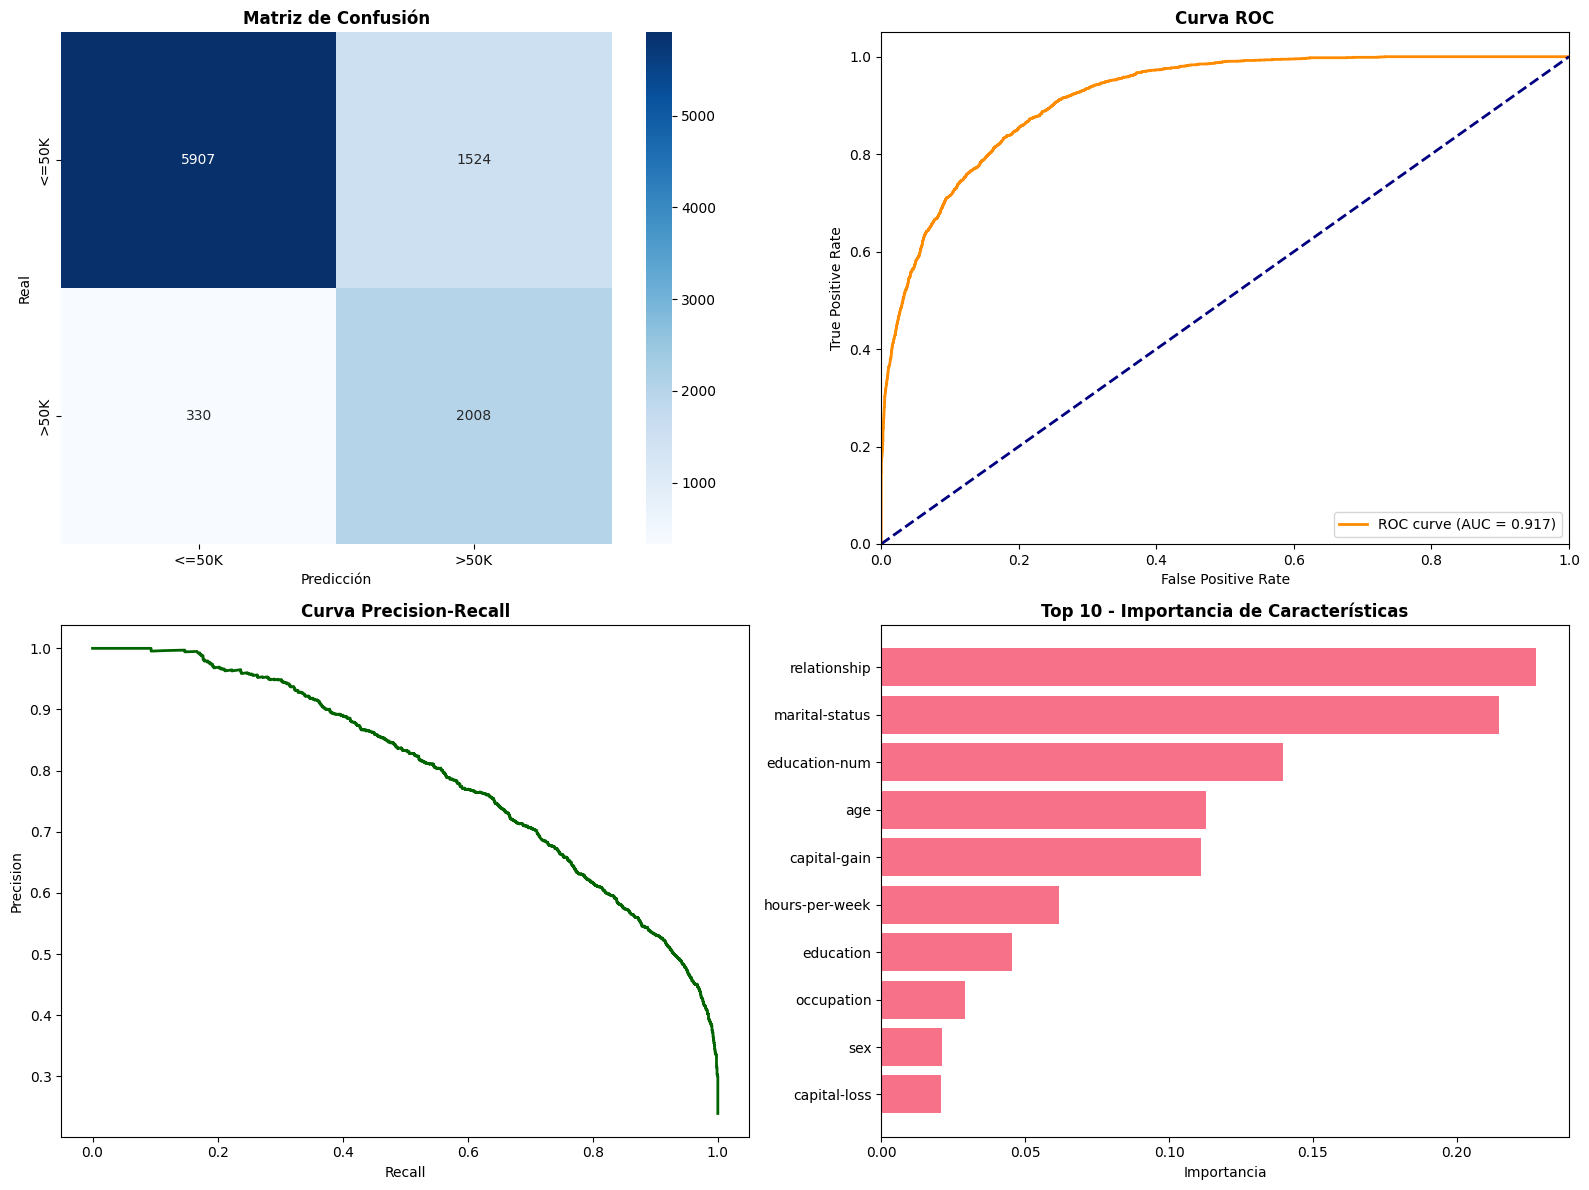

In [13]:
results = predictor.evaluate_model()

In [16]:
bias_analysis = predictor.analyze_bias_by_groups()


🚨 ANÁLISIS DE SESGOS ALGORÍTMICOS

🔍 Variable: SEX
Grupo                n      Acc    F1     Pred+%  Real+%  Sesgo 
-----------------------------------------------------------------
Male                 6480   0.762  0.693  0.473   0.304   ⚠️
Female               3289   0.906  0.628  0.142   0.112   ⚠️

🔍 Variable: RACE
Grupo                n      Acc    F1     Pred+%  Real+%  Sesgo 
-----------------------------------------------------------------
Asian-Pac-Islander   304    0.796  0.687  0.395   0.257   ⚠️
White                8348   0.802  0.689  0.384   0.254   ⚠️
Amer-Indian-Eskimo   104    0.788  0.389  0.260   0.087   ⚠️
Other                69     0.870  0.640  0.203   0.159   ⚠️
Black                944    0.888  0.632  0.177   0.128   ⚠️

🔍 Variable: NATIVE-COUNTRY
Grupo                n      Acc    F1     Pred+%  Real+%  Sesgo 
-----------------------------------------------------------------
India                31     0.774  0.811  0.677   0.516   ⚠️
Iran                 

In [15]:
top_features = results['feature_importance'].head(10)
for i, (_, row) in enumerate(top_features.iterrows(), 1):
    print(f"   {i:2d}. {row['feature']:<20}: {row['importance']:.4f}")

    1. relationship        : 0.2276
    2. marital-status      : 0.2148
    3. education-num       : 0.1396
    4. age                 : 0.1127
    5. capital-gain        : 0.1112
    6. hours-per-week      : 0.0619
    7. education           : 0.0456
    8. occupation          : 0.0291
    9. sex                 : 0.0211
   10. capital-loss        : 0.0209


## Mitigación de sesgos

In [19]:
class FairnessMetrics:
    """Métricas de equidad algorítmica"""

    @staticmethod
    def demographic_parity(y_true, y_pred, sensitive_attr):
        """Paridad demográfica: tasas de predicción positiva iguales por grupo"""
        groups = np.unique(sensitive_attr)
        rates = {}
        for group in groups:
            mask = sensitive_attr == group
            if np.sum(mask) > 0:
                rates[group] = np.mean(y_pred[mask])
        return rates

    @staticmethod
    def equalized_odds(y_true, y_pred, sensitive_attr):
        """Odds equalizadas: TPR y FPR iguales por grupo"""
        groups = np.unique(sensitive_attr)
        metrics = {}
        for group in groups:
            mask = sensitive_attr == group
            if np.sum(mask) > 20:  # Solo grupos con suficientes datos
                y_true_group = y_true[mask]
                y_pred_group = y_pred[mask]

                if len(np.unique(y_true_group)) > 1:
                    tn, fp, fn, tp = confusion_matrix(y_true_group, y_pred_group).ravel()
                    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
                    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
                    metrics[group] = {'TPR': tpr, 'FPR': fpr}
                else:
                    metrics[group] = {'TPR': np.nan, 'FPR': np.nan}
        return metrics

    @staticmethod
    def disparity_ratio(rates_dict):
        """Ratio de disparidad máx/mín"""
        valid_rates = [v for v in rates_dict.values() if not pd.isna(v) and v > 0]
        if len(valid_rates) < 2:
            return np.nan
        return max(valid_rates) / min(valid_rates)

In [20]:
class FairRandomForest:
    """Random Forest con estrategias de mitigación de sesgos"""

    def __init__(self, strategy='combined', random_state=42):
        self.strategy = strategy
        self.random_state = random_state
        self.model = None
        self.encoders = {}
        self.group_thresholds = {}
        self.sensitive_attrs = ['sex', 'race', 'native-country']
        self.feature_names = None

    def encode_features(self, X, fit_encoders=True):
        """Codificar variables categóricas"""
        X_encoded = X.copy()
        categorical_cols = X_encoded.select_dtypes(include=['object']).columns

        for col in categorical_cols:
            if fit_encoders:
                self.encoders[col] = LabelEncoder()
                X_encoded[col] = self.encoders[col].fit_transform(X_encoded[col].astype(str))
            else:
                if col in self.encoders:
                    # Manejar valores nuevos
                    unique_vals = X_encoded[col].astype(str).unique()
                    known_vals = set(self.encoders[col].classes_)
                    new_vals = set(unique_vals) - known_vals

                    if new_vals:
                        # Asignar valores nuevos a la clase más frecuente
                        most_frequent_encoded = 0
                        mask = X_encoded[col].astype(str).isin(new_vals)
                        X_encoded.loc[mask, col] = self.encoders[col].classes_[most_frequent_encoded]

                    X_encoded[col] = self.encoders[col].transform(X_encoded[col].astype(str))

        return X_encoded

    def apply_rebalancing_strategy(self, X, y):
        """Estrategia 1: Rebalanceo interseccional"""
        print("🎯 Aplicando rebalanceo interseccional...")

        # Identificar grupos subrepresentados
        group_stats = self.analyze_intersectional_groups(X, y)

        X_rebalanced = X.copy()
        y_rebalanced = y.copy()

        # Generar muestras sintéticas para grupos desfavorecidos
        for group_key, stats in group_stats.items():
            if stats['positive_rate'] < 0.15 and stats['count'] > 50:  # Grupos significativos subrepresentados
                # Sobre-muestrear clase positiva de este grupo
                group_mask = self.get_group_mask(X, group_key)
                group_positive_mask = group_mask & (y == 1)

                if np.sum(group_positive_mask) > 0:
                    # Duplicar muestras positivas
                    positive_samples = X[group_positive_mask]
                    positive_targets = y[group_positive_mask]

                    n_duplicates = min(50, np.sum(group_mask) // 4)

                    for _ in range(n_duplicates):
                        idx = np.random.randint(len(positive_samples))
                        X_rebalanced = pd.concat([X_rebalanced, positive_samples.iloc[idx:idx+1]])
                        y_rebalanced = pd.concat([y_rebalanced, positive_targets.iloc[idx:idx+1]])

        print(f"   Dataset: {len(X)} → {len(X_rebalanced)} muestras")
        return X_rebalanced.reset_index(drop=True), y_rebalanced.reset_index(drop=True)

    def apply_smote_strategy(self, X, y):
        """Estrategia 2: SMOTE con consideraciones de equidad"""
        print("🎯 Aplicando SMOTE interseccional...")

        try:
            # SMOTE moderado para evitar overfitting
            smote = SMOTE(random_state=self.random_state, k_neighbors=5, sampling_strategy=0.4)
            X_smote, y_smote = smote.fit_resample(X, y)
            print(f"   SMOTE: {len(X)} → {len(X_smote)} muestras")
            return pd.DataFrame(X_smote, columns=X.columns), pd.Series(y_smote)
        except Exception as e:
            print(f"   ⚠️ SMOTE falló: {e}")
            return X, y

    def apply_combined_strategy(self, X, y):
        """Estrategia 3: Combinada (rebalanceo + SMOTE leve)"""
        print("🎯 Aplicando estrategia combinada...")

        # Primero rebalanceo
        X_rebal, y_rebal = self.apply_rebalancing_strategy(X, y)

        # Luego SMOTE muy leve si es necesario
        positive_rate = np.mean(y_rebal)
        if positive_rate < 0.3:
            try:
                smote = SMOTE(random_state=self.random_state, k_neighbors=3, sampling_strategy=0.35)
                X_final, y_final = smote.fit_resample(X_rebal, y_rebal)
                return pd.DataFrame(X_final, columns=X_rebal.columns), pd.Series(y_final)
            except:
                pass

        return X_rebal, y_rebal

    def analyze_intersectional_groups(self, X, y):
        """Analizar grupos interseccionales"""
        group_stats = {}

        # Analizar intersecciones simples (dos variables)
        sensitive_pairs = [
            ('sex', 'race'),
            ('sex', 'native-country'),
            ('race', 'native-country')
        ]

        for attr1, attr2 in sensitive_pairs:
            if attr1 in X.columns and attr2 in X.columns:
                for val1 in X[attr1].unique()[:3]:  # Top 3 valores
                    for val2 in X[attr2].unique()[:3]:
                        mask = (X[attr1] == val1) & (X[attr2] == val2)
                        if np.sum(mask) > 10:
                            group_key = f"{attr1}_{val1}_{attr2}_{val2}"
                            group_stats[group_key] = {
                                'count': np.sum(mask),
                                'positive_rate': np.mean(y[mask]),
                                'mask_attrs': [(attr1, val1), (attr2, val2)]
                            }

        return group_stats

    def get_group_mask(self, X, group_key):
        """Obtener máscara para un grupo específico"""
        # Simplificado: usar solo primera variable sensible
        if 'sex_' in group_key:
            if 'Male' in group_key:
                return X['sex'] == 'Male'
            elif 'Female' in group_key:
                return X['sex'] == 'Female'
        return pd.Series([False] * len(X))

    def calibrate_thresholds(self, X, y, y_proba):
        """Calibrar umbrales por grupo para equidad"""
        print("🎯 Calibrando umbrales por grupo...")

        for attr in self.sensitive_attrs:
            if attr in X.columns:
                self.group_thresholds[attr] = {}

                for group_val in X[attr].unique():
                    mask = X[attr] == group_val
                    if np.sum(mask) > 30:  # Solo grupos suficientemente grandes
                        group_proba = y_proba[mask]
                        group_y = y[mask]

                        # Buscar umbral óptimo para F1-score
                        best_threshold = 0.5
                        best_f1 = 0

                        for threshold in np.arange(0.1, 0.9, 0.05):
                            pred = (group_proba >= threshold).astype(int)
                            if len(np.unique(pred)) > 1:
                                f1 = f1_score(group_y, pred)
                                if f1 > best_f1:
                                    best_f1 = f1
                                    best_threshold = threshold

                        self.group_thresholds[attr][group_val] = best_threshold
                        print(f"   {attr}={group_val}: umbral={best_threshold:.3f}")

    def fit(self, X, y):
        """Entrenar modelo con estrategia seleccionada"""
        print(f"\n🚀 ENTRENANDO RANDOM FOREST V2.0")
        print(f"🛡️ Estrategia de equidad: {self.strategy.upper()}")
        print("-" * 60)

        # Guardar nombres de características
        self.feature_names = list(X.columns)

        # Codificar características
        X_encoded = self.encode_features(X, fit_encoders=True)

        # Aplicar estrategia de mitigación
        if self.strategy == 'rebalancing':
            X_processed, y_processed = self.apply_rebalancing_strategy(X_encoded, y)
        elif self.strategy == 'smote':
            X_processed, y_processed = self.apply_smote_strategy(X_encoded, y)
        elif self.strategy == 'combined':
            X_processed, y_processed = self.apply_combined_strategy(X_encoded, y)
        else:  # baseline
            X_processed, y_processed = X_encoded, y

        print(f"📊 Dataset final: {len(X_processed)} muestras")
        print(f"📈 Tasa clase positiva: {np.mean(y_processed):.3f}")

        # Calcular pesos balanceados
        if self.strategy != 'smote':  # SMOTE ya balancea
            class_weights = compute_class_weight('balanced', classes=np.unique(y_processed), y=y_processed)
            class_weight_dict = dict(zip(np.unique(y_processed), class_weights))
        else:
            class_weight_dict = None

        # Configurar Random Forest optimizado para equidad
        self.model = RandomForestClassifier(
            n_estimators=150,
            max_depth=12,
            min_samples_split=25,
            min_samples_leaf=15,
            max_features='sqrt',
            class_weight=class_weight_dict,
            random_state=self.random_state,
            n_jobs=-1
        )

        # Entrenar
        self.model.fit(X_processed, y_processed)

        # Calibrar umbrales por grupo
        y_proba = self.model.predict_proba(X_processed)[:, 1]
        self.calibrate_thresholds(X_processed, y_processed, y_proba)

        print("✅ Entrenamiento completado")
        return self

    def predict(self, X):
        """Predicción con umbrales calibrados"""
        X_encoded = self.encode_features(X, fit_encoders=False)
        y_proba = self.model.predict_proba(X_encoded)[:, 1]
        y_pred = (y_proba >= 0.5).astype(int)

        # Aplicar umbrales calibrados por grupo
        for attr in self.sensitive_attrs:
            if attr in X_encoded.columns and attr in self.group_thresholds:
                for group_val, threshold in self.group_thresholds[attr].items():
                    mask = X_encoded[attr] == group_val
                    if np.sum(mask) > 0:
                        y_pred[mask] = (y_proba[mask] >= threshold).astype(int)

        return y_pred

    def predict_proba(self, X):
        """Probabilidades de predicción"""
        X_encoded = self.encode_features(X, fit_encoders=False)
        return self.model.predict_proba(X_encoded)

    def get_feature_importance(self):
        """Importancia de características"""
        if self.model is None:
            return None

        importance = pd.DataFrame({
            'feature': self.feature_names,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)

        return importance

In [21]:
def comprehensive_fairness_evaluation(model, X_test, y_test, model_name="Modelo"):
    """Evaluación exhaustiva de equidad"""

    print(f"\n📊 EVALUACIÓN DE EQUIDAD - {model_name.upper()}")
    print("=" * 70)

    # Predicciones
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Métricas generales
    print(f"\n🎯 RENDIMIENTO GENERAL:")
    print(f"   Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
    print(f"   F1-Score:  {f1_score(y_test, y_pred):.3f}")
    print(f"   Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"   Recall:    {recall_score(y_test, y_pred):.3f}")
    print(f"   AUC-ROC:   {roc_auc_score(y_test, y_proba):.3f}")

    # Análisis de equidad por atributos sensibles
    fairness_results = {}

    for attr in ['sex', 'race', 'native-country']:
        if attr in X_test.columns:
            print(f"\n⚖️ ANÁLISIS DE EQUIDAD - {attr.upper()}:")
            print("-" * 40)

            # Obtener valores del atributo
            attr_values = X_test[attr] if attr not in model.encoders else [
                model.encoders[attr].inverse_transform([val])[0] for val in X_test[attr]
            ]

            # Paridad demográfica
            dp_rates = FairnessMetrics.demographic_parity(y_test, y_pred, attr_values)
            dp_ratio = FairnessMetrics.disparity_ratio(dp_rates)

            print(f"   📈 PARIDAD DEMOGRÁFICA:")
            for group, rate in dp_rates.items():
                count = sum(1 for v in attr_values if v == group)
                status = "🔴" if rate > np.mean(list(dp_rates.values())) * 1.2 else "🟡" if rate < np.mean(list(dp_rates.values())) * 0.8 else "🟢"
                print(f"     {group:20s}: {rate:.3f} (n={count:,}) {status}")

            print(f"   📊 Ratio de Disparidad: {dp_ratio:.2f} {'🔴' if dp_ratio > 2.0 else '🟡' if dp_ratio > 1.5 else '🟢'}")

            # Equalized Odds
            eo_metrics = FairnessMetrics.equalized_odds(y_test, y_pred, attr_values)
            if eo_metrics:
                print(f"   ⚖️ EQUALIZED ODDS:")
                tprs, fprs = [], []
                for group, metrics in eo_metrics.items():
                    if not pd.isna(metrics['TPR']):
                        tprs.append(metrics['TPR'])
                        fprs.append(metrics['FPR'])
                        print(f"     {group:20s}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

                if len(tprs) > 1:
                    tpr_diff = max(tprs) - min(tprs)
                    fpr_diff = max(fprs) - min(fprs)
                    print(f"   📈 Diferencias: TPR={tpr_diff:.3f}, FPR={fpr_diff:.3f}")

            # Guardar resultados
            fairness_results[attr] = {
                'demographic_parity': dp_rates,
                'disparity_ratio': dp_ratio,
                'equalized_odds': eo_metrics
            }

    return {
        'performance': {
            'accuracy': accuracy_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'auc_roc': roc_auc_score(y_test, y_proba)
        },
        'fairness': fairness_results
    }

In [22]:
def compare_bias_reduction(results_v1, results_v2, strategy_name):
    """Comparar reducción de sesgos entre modelos"""

    print(f"\n🔄 COMPARACIÓN: V1.0 vs V2.0 ({strategy_name.upper()})")
    print("=" * 80)

    # Comparar métricas generales
    perf_v1 = results_v1['performance']
    perf_v2 = results_v2['performance']

    print(f"\n📊 RENDIMIENTO:")
    print(f"   Accuracy:  {perf_v1['accuracy']:.3f} → {perf_v2['accuracy']:.3f} ({perf_v2['accuracy']-perf_v1['accuracy']:+.3f})")
    print(f"   F1-Score:  {perf_v1['f1_score']:.3f} → {perf_v2['f1_score']:.3f} ({perf_v2['f1_score']-perf_v1['f1_score']:+.3f})")
    print(f"   AUC-ROC:   {perf_v1['auc_roc']:.3f} → {perf_v2['auc_roc']:.3f} ({perf_v2['auc_roc']-perf_v1['auc_roc']:+.3f})")

    # Comparar sesgos
    bias_improvements = []

    for attr in ['sex', 'race', 'native-country']:
        if attr in results_v1['fairness'] and attr in results_v2['fairness']:
            ratio_v1 = results_v1['fairness'][attr]['disparity_ratio']
            ratio_v2 = results_v2['fairness'][attr]['disparity_ratio']

            if not pd.isna(ratio_v1) and not pd.isna(ratio_v2):
                improvement = (ratio_v1 - ratio_v2) / (ratio_v1 - 1) * 100 if ratio_v1 > 1 else 0
                bias_improvements.append(improvement)

                print(f"\n🛡️ SESGO {attr.upper()}:")
                print(f"   Ratio Disparidad: {ratio_v1:.2f} → {ratio_v2:.2f}")
                print(f"   Mejora: {improvement:.1f}% {'✅' if improvement > 10 else '⚠️' if improvement > 0 else '❌'}")

    # Resumen
    avg_bias_reduction = np.mean(bias_improvements) if bias_improvements else 0
    print(f"\n🏆 RESUMEN:")
    print(f"   Reducción promedio de sesgos: {avg_bias_reduction:.1f}%")
    print(f"   Trade-off rendimiento: {perf_v2['f1_score']-perf_v1['f1_score']:+.1%}")

    return avg_bias_reduction

In [24]:
X = pd.read_csv('data/X_processed.csv')
y = pd.read_csv('data/y_processed.csv')['income']
y_binary = (y == '>50K').astype(int)

In [25]:
print(f"   ✅ Dataset: {len(X)} muestras, {len(X.columns)} características")
print(f"   📈 Clase positiva: {np.mean(y_binary):.1%}")

   ✅ Dataset: 48842 muestras, 13 características
   📈 Clase positiva: 23.9%


In [26]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y_binary, test_size=0.2, random_state=42, stratify=y_binary)